# STOCHASTIC CLIMATE EMULATORS FOR COASTAL HAZARDS
### UCSC - Nov 2024


<img src="images/Image_3.png" alt="Texto alternativo" width="400">  


## TESLA: 03 - ANNUAL WEATHER TYPE (AWT) - AUTOREGRESSIVE LOGISTIC REGRESSION MODEL (ALR)



---

Fernando J.Mendez (fernando.mendez@unican.es)

Full Profesor at the Univeristy of Cantabria

---

Jared Ortiz-Angulo Cantos (ortizanguloj@unican.es)

Researcher

---

Geomatics and Ocean Engineering Group

Civil Engineering School, University of Cantabria

<img src="images/Image_1.png" alt="Texto alternativo" width="200">               <img src="images/Image_2.jpeg" alt="Texto alternativo" width="200">

<img src="images/Image_4.jpeg" alt="Texto alternativo" width="800"> 

© GeoOcean 2024 - University of Cantabria


---

Inputs required:
  * AWT_PCs_from_DWT.nc : Generated in 02_AWT_TESLA

  
In this notebook:
  1. Import required libraries and paths
  2. Load AWT Data
  3. Synthehic AWT Generation
  4. Autoregressive Logistic Regression (ALR) - Fit
  5. Autoregressive Logistic Regression (ALR) - Simulation
  6. Save data 


---

## **1. Import required libraries and paths**

In [1]:
import warnings
warnings.filterwarnings('ignore')

import sys

import numpy as np
import xarray as xr
import os
import os.path as op
import matplotlib.pyplot as plt
from matplotlib import gridspec
import pandas as pd
import pickle as pkl

from datetime import datetime

In [2]:
from bluemath_tk.teslakit.statistical import CopulaSimulation
from bluemath_tk.teslakit.alr import ALR_WRP
from bluemath_tk.teslakit.plotting.pcs import Plot_PCs_Compare_3D, Plot_PCs_WT

In [3]:
# paths
p_dat = ('/workspaces/TESLA_UCSC/data')
p_out = ('/workspaces/TESLA_UCSC/results')

In [4]:
pcs_awt = xr.open_dataset(op.join(p_out, 'AWT_PCs_from_DWT.nc'))
p_alr_awt = op.join(p_out, 'awt_alr')

---

## **2. LOAD AWT DATA**

In [5]:
# PCs copula generation parameters (PCs 1, 2, 3)
num_PCs_rnd = 1000
kernels = ['KDE', 'KDE', 'KDE']

In [14]:
alr_markov_order = 1

# SST Predictor PCA parameters
pca_year_ini = pcs_awt.time.min().values
pca_year_end = pcs_awt.time.max().values
pca_month_ini = 1
pca_month_end = 12
num_clusters = 5
repres = 0.95

In [15]:
# Simulation
num_sims = 100
y1_sim = 1900
y2_sim = 2000

---

## **3. SYNTHETIC AWT GENERATION**


In [16]:
# --------------------------------------
# PCs123 random generation with Copulas

bmus = pcs_awt.AWT.values[:]
PCs  = pcs_awt.PCs.values[:]
vari = np.std(PCs, axis=0)

# first 3 PCs
PC1 = np.divide(PCs[:,0], np.sqrt(vari[0]))
PC2 = np.divide(PCs[:,1], np.sqrt(vari[1]))
PC3 = np.divide(PCs[:,2], np.sqrt(vari[2]))

# for each AWT: generate copulas and simulate data
PCs_fit = {}
PCs_rnd = {}
for ic in range(num_clusters):

    # find all the best match units
    ind = np.where(bmus == ic)[:]

    # PCs for weather type
    PC123 = np.column_stack((PC1[ind], PC2[ind], PC3[ind]))

    # statistical simulate PCs using copulas with KDE (kernel density estimation)
    PC123_rnd = CopulaSimulation(PC123, kernels, num_PCs_rnd)

    # store data at dictionaries
    PCs_fit['{0}'.format(ic+1)] = PC123
    PCs_rnd['{0}'.format(ic+1)] = PC123_rnd

# store PCs used for fitting and simulated
pkl.dump(PCs_fit, open(op.join(p_out, 'AWT_PCs_fit.pkl'), 'wb'))
pkl.dump(PCs_rnd, open(op.join(p_out, 'AWT_PCs_rnd_{0}.nc'.format(num_PCs_rnd)), 'wb'))


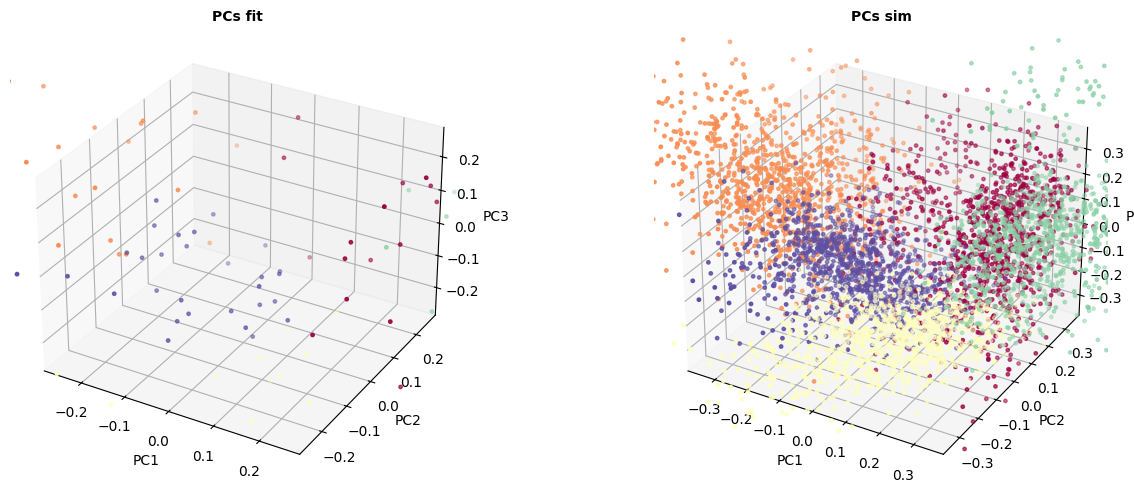

In [17]:
Plot_PCs_Compare_3D(PCs_fit, PCs_rnd);

---

## **4. AUTOREGRESSIVE LOGISTIC REGRESSION - FIT**




In [18]:
pcs_awt['AWT'] = pcs_awt['AWT'] +1

In [19]:
# --------------------------------------
# Autoregressive Logistic Regression - fit model

# bmus series
bmus_fit = pcs_awt.rename({'AWT':'bmus'}).drop(['PCs', 'n_pcs'])

# ALR terms
d_terms_settings = {
    'mk_order'  : alr_markov_order,
    'constant' : True,
    'long_term' : False,
    'seasonality': (False, []),
}

# ALR wrapper
ALRW = ALR_WRP(p_alr_awt)
ALRW.SetFitData(num_clusters, bmus_fit, d_terms_settings)

# ALR model fitting
ALRW.FitModel(max_iter=50000)


Fitting autoregressive logistic model ...
Optimization done in 0.42 seconds



---

## **5. AUTOREGRESSIVE LOGISTIC REGRESSION - SIMULATION**


In [20]:
# --------------------------------------
# Autoregressive Logistic Regression - simulate

# simulation dates (annual array)
dates_sim = [datetime(y, pca_month_ini,1) for y in range(y1_sim-1, y2_sim+1)]

# launch simulation
ALR_sim = ALRW.Simulate(num_sims, dates_sim)

# store simulated Annual Weather Types
SST_AWTs_sim = ALR_sim.evbmus_sims.to_dataset()
print(SST_AWTs_sim)

#db.Save_SST_AWT_sim(SST_AWTs_sim)
# SST_AWTs_sim.to_netcdf(op.join(p_dat, 'outputs', 'AWT_SIM_nsims{0}_{1}_{2}.nc'.format(num_sims, y1_sim, y2_sim)))


ALR model fit   : 1940-01-01 --- 2023-01-01
ALR model sim   : 1899-01-01 --- 2000-01-01

Launching 100 simulations...

Sim. Num. 100: 100%|██████████| 101/101 [00:00<00:00, 3159.44it/s]

<xarray.Dataset> Size: 82kB
Dimensions:      (time: 102, n_sim: 100)
Coordinates:
  * time         (time) datetime64[ns] 816B 1899-01-01 1900-01-01 ... 2000-01-01
Dimensions without coordinates: n_sim
Data variables:
    evbmus_sims  (time, n_sim) int64 82kB 4 4 4 4 4 4 4 4 4 ... 5 5 5 2 1 2 5 5


PerpetualYear bmus comparison skipped.
timedelta (days): Hist - 366, Sim - 365)


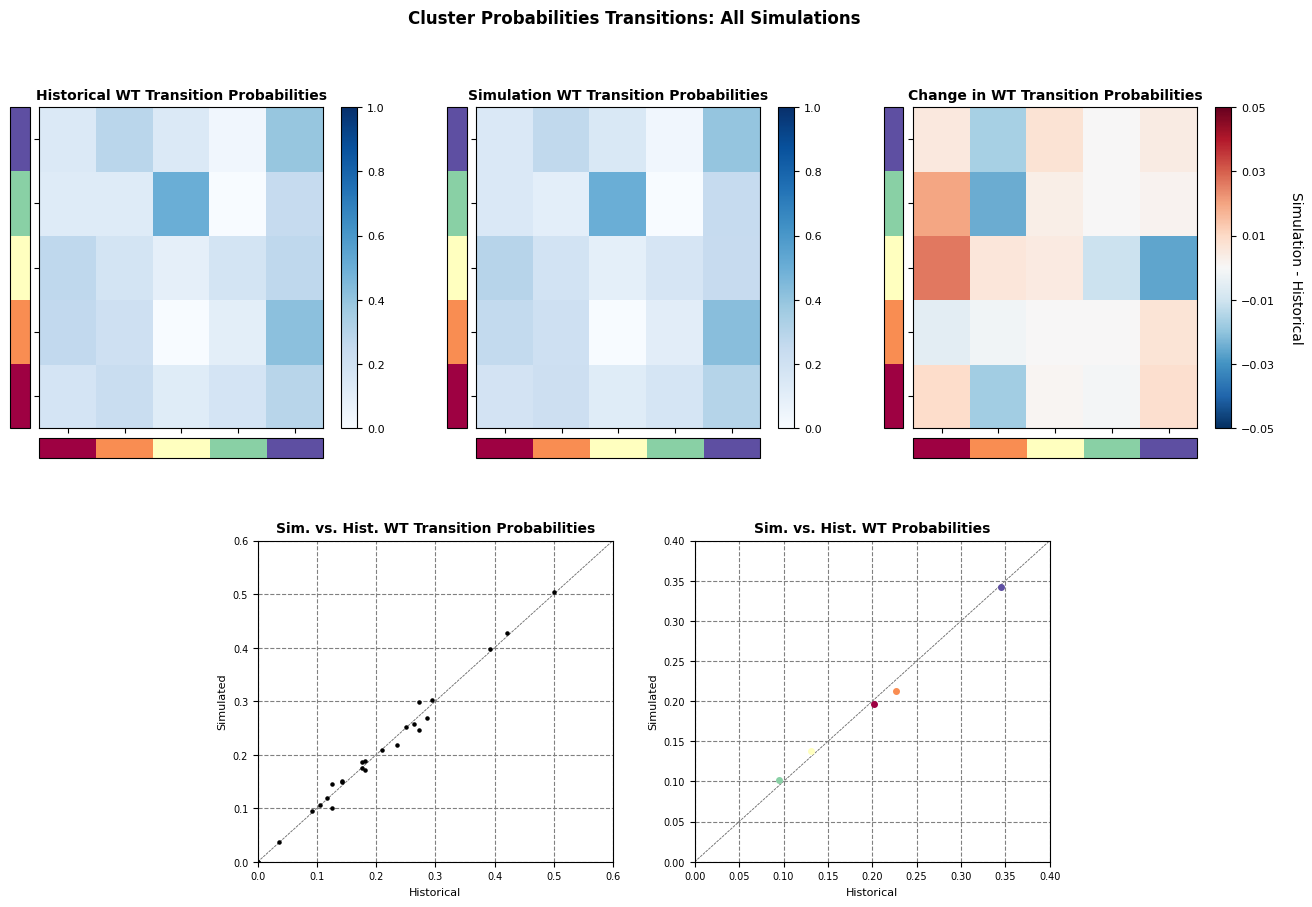

In [21]:
# show simulation report
ALRW.Report_Sim();

In [22]:
# --------------------------------------
# PCs generation

# solve each ALR simulation
l_PCs_sim = []
for s in SST_AWTs_sim.n_sim:

    evbmus_sim = SST_AWTs_sim.sel(n_sim=s).evbmus_sims.values[:]

    # generate random PCs
    pcs123_sim = np.empty((len(evbmus_sim),3)) * np.nan
    for c, m in enumerate(evbmus_sim):
        options = PCs_rnd['{0}'.format(int(m))]
        r = np.random.randint(options.shape[0])
        pcs123_sim[c,:] = options[r,:]

    # denormalize simulated PCs
    PC1_sim = np.multiply(pcs123_sim[:,0], np.sqrt(vari[0]))
    PC2_sim = np.multiply(pcs123_sim[:,1], np.sqrt(vari[1]))
    PC3_sim = np.multiply(pcs123_sim[:,2], np.sqrt(vari[2]))

    # append simulated PCs
    l_PCs_sim.append(
        xr.Dataset(
            {
                'PC1'  : (('time',), PC1_sim),
                'PC2'  : (('time',), PC2_sim),
                'PC3'  : (('time',), PC3_sim),
                'evbmus_sim' : (('time',), evbmus_sim),
            },
            {'time' : dates_sim}
        )
    )

# concatenate simulations
SST_PCs_sim = xr.concat(l_PCs_sim, 'n_sim')
print(SST_PCs_sim)

# store simulated PCs
#db.Save_SST_PCs_sim(SST_PCs_sim)
# SST_PCs_sim.to_netcdf(op.join(p_dat, 'outputs', 'AWT_SIM_PCs_nsims{0}_{1}_{2}.nc'.format(num_sims, y1_sim, y2_sim)))


<xarray.Dataset> Size: 327kB
Dimensions:     (n_sim: 100, time: 102)
Coordinates:
  * time        (time) datetime64[ns] 816B 1899-01-01 1900-01-01 ... 2000-01-01
Dimensions without coordinates: n_sim
Data variables:
    PC1         (n_sim, time) float64 82kB 0.08529 0.002684 ... 0.07664 -0.01505
    PC2         (n_sim, time) float64 82kB 0.006586 -0.09792 ... -0.001364
    PC3         (n_sim, time) float64 82kB 0.05392 0.0186 ... 0.02678 -0.02007
    evbmus_sim  (n_sim, time) int64 82kB 4 3 2 4 5 3 5 1 3 ... 4 1 5 2 5 5 3 1 5


---

## **6. SAVE DATA**

In [23]:
SST_PCs_sim.to_netcdf(op.join(p_out, 'AWT_ALR.nc'))